# Imports and Constants

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import tensorflow as tf

In [ ]:
from collections import defaultdict
import itertools
import pickle
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from batchers import dataset_constants
from utils.analysis import (
    calc_score,
    chunk_vs_score,
    evaluate_df,
    plot_chunk_vs_score,
    plot_label_vs_score,
    plot_percdata_vs_score,
    sorted_scores)
from utils.general import colordisplay, load_npz
from utils.plot import scatter_preds, symmetric_heatmap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
LOGS_ROOT_DIR = 'drive/MyDrive/USP/TCC/data/training2/idhm/income'
MODEL_NAME_TO_DIR = {
    # Resnet
    'MS': 'resnet_ms',
    'MS+NL': 'resnet_msnl_concat',
    'NL': 'resnet_nl',
    'RGB': 'resnet_rgb'
}

MODEL_NAMES = sorted(MODEL_NAME_TO_DIR.keys())

# Load Saved Data

## Load `labels`, `locs`, and `years`

In [ ]:
npz = load_npz('drive/MyDrive/USP/TCC/data/training2/idhm/income/income_image_hists.npz')

labels = npz['labels']
locs = npz['locs']
years = npz['years']
nls_center = npz['nls_center']
nls_mean = npz['nls_mean']

num_examples = len(labels)
assert np.all(np.asarray([len(labels), len(locs), len(years), len(nls_center), len(nls_mean)]) == num_examples)

image_hists: dtype=int64, shape=(9748, 8, 102)
labels: dtype=float32, shape=(9748,)
locs: dtype=float32, shape=(9748, 2)
years: dtype=int32, shape=(9748,)
nls_center: dtype=float32, shape=(9748,)
nls_mean: dtype=float32, shape=(9748,)


## Load `loc_dict`

`loc_dict` has the format:
```python
{
    (lat, lon): {
        'cluster': 1,
        'country': 'malawi',
        'country_year': 'malawi_2012',  # surveyID
        'households': 25,
        'urban': 0,
        'wealth': -0.513607621192932,
        'wealthpooled': -0.732255101203918,
        'year': 2012
    },
    ...
}
```

NOTE: `year` and `country_year` might differ in the year. `country_year` is the survey ID, which says which year the survey started. However, sometimes the DHS surveys cross the year-boundary, in which case `country_year` will remain the same but `year` will be the next year.

In [ ]:
loc_dict_path = 'drive/MyDrive/USP/TCC/data/vr_loc_dict_3.pkl'
with open(loc_dict_path, 'rb') as f:
    loc_dict = pickle.load(f)
    


## Get urban v. rural indices

## `country_indices` and `country_labels`

`country_indices` is a dictionary that maps a country name to a sorted `np.array` of its indices
```python
{ 'malawi': np.array([ 8530,  8531,  8532, ..., 10484, 10485, 10486]), ... }
```

`country_labels` is a `np.array` that shows which country each example belongs to
```python
np.array([0, 0, 0, 0, ..., 22, 22, 22])
```
where countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`

In [ ]:
municipalities = np.asarray(dataset_constants.IDHM_MUNICIPALITIES)

In [ ]:
municipality_indices = defaultdict(list)  # country => np.array of indices

print(len(locs))
municipality_labels = np.zeros(num_examples, dtype=np.int32)  # np.array of country labels

for i, loc in enumerate(locs):
    municipality = loc_dict[tuple(loc)]['group']
    municipality_indices[municipality].append(i)

for i, municipality in enumerate(municipalities):
    municipality_indices[municipality] = np.asarray(municipality_indices[municipality])
    indices = municipality_indices[municipality]
    municipality_labels[indices] = i

municipality_indices['overall'] = np.arange(num_examples)

9748


In [ ]:
municipality_year_indices = defaultdict(list)

for i, (lat, lon) in enumerate(locs):
    cy = loc_dict[(lat, lon)]['group_year']
    municipality_year_indices[cy].append(i)

for cy in municipality_year_indices:
    municipality_year_indices[cy] = np.asarray(municipality_year_indices[cy])

# Load saved preds

In [ ]:
preds = {}

for model_name, model_dir in MODEL_NAME_TO_DIR.items():
    npz_path = os.path.join(LOGS_ROOT_DIR, model_dir, 'test_preds.npz')
    preds[model_name] = load_npz(npz_path)['test_preds']

locs: dtype=float32, shape=(9748, 2)
labels: dtype=float32, shape=(9748,)
test_preds: dtype=float32, shape=(9748,)
locs: dtype=float32, shape=(9748, 2)
labels: dtype=float32, shape=(9748,)
test_preds: dtype=float32, shape=(9748,)
locs: dtype=float32, shape=(9748, 2)
labels: dtype=float32, shape=(9748,)
test_preds: dtype=float32, shape=(9748,)
locs: dtype=float32, shape=(9748, 2)
labels: dtype=float32, shape=(9748,)
test_preds: dtype=float32, shape=(9748,)


In [ ]:
preds

{'MS': array([0.6559328, 0.6522387, 0.6504017, ..., 0.7146915, 0.7181573,
        0.6568086], dtype=float32),
 'MS+NL': array([0.6547191 , 0.6521777 , 0.6562493 , ..., 0.70721656, 0.70939785,
        0.6623732 ], dtype=float32),
 'NL': array([0.6884977 , 0.68688965, 0.6923117 , ..., 0.6868817 , 0.6868817 ,
        0.6868817 ], dtype=float32),
 'RGB': array([0.67585474, 0.6741485 , 0.6800618 , ..., 0.7102394 , 0.70913154,
        0.67547953], dtype=float32)}

In [ ]:
cell_id = []
for i, (lat,lon) in enumerate(locs):
  loc = (lat,lon)
  cell_id.append(loc_dict[loc]['cluster'])

## Create CSV of all preds

In [ ]:
preds_df = pd.DataFrame(
    columns=['cell_id', 'lat', 'lon', 'group', 'year', 'label'] + MODEL_NAMES)
preds_df['cell_id'] = cell_id
preds_df['lat'] = locs[:, 0]
preds_df['lon'] = locs[:, 1]
preds_df['label'] = labels
preds_df['year'] = years
preds_df['group'] = np.asarray(municipalities)[municipality_labels] # attention is saving group_year


for model_name in MODEL_NAMES:
    preds_df[model_name] = preds[model_name]

#preds_df.to_csv('income_preds_ooc.csv', index=False)

In [ ]:
with pd.option_context('display.max_rows', 8):
    display(preds_df)

,cell_id,lat,lon,group,year,label,MS,MS+NL,NL,RGB
0,2916,-26.314129,-51.276913,group10,2010,0.663630,0.655933,0.654719,0.688498,0.675855
1,2917,-26.252384,-51.277557,group10,2010,0.668222,0.652239,0.652178,0.686890,0.674148
2,2918,-26.190659,-51.278202,group10,2010,0.670894,0.650402,0.656249,0.692312,0.680062
3,2919,-26.128948,-51.278847,group10,2010,0.672917,0.641633,0.648709,0.692324,0.674156
...,...,...,...,...,...,...,...,...,...,...
9744,2912,-20.635338,-51.400368,group9,2010,0.682000,0.713102,0.709272,0.699436,0.707904
9745,2913,-20.574833,-51.400970,group9,2010,0.696546,0.714692,0.707217,0.686882,0.710239
9746,2914,-20.514338,-51.401573,group9,2010,0.697681,0.718157,0.709398,0.686882,0.709132
9747,2915,-26.561281,-51.274334,group9,2010,0.638000,0.656809,0.662373,0.686882,0.675480


# Overall MSE, $R^2$, $r^2$, rank-corr

### Model 1 to 5 separate analysis

In [ ]:
preds_df_model1 = preds_df[preds_df['group'].isin(dataset_constants._SURVEY_NAMES_IDHM_OOC_A['test'])]    
model1_df = evaluate_df(preds_df_model1, cols=MODEL_NAMES)
model1_df.sort_values(by='R2', ascending=False, inplace=True)
display(model1_df)

,r2,R2,mse,rank
MS+NL,0.407445,0.393423,0.000997,0.615094
MS,0.403699,0.391751,0.000999,0.607407
RGB,0.180064,0.176445,0.001353,0.396500
NL,0.170081,0.155883,0.001387,0.330983


In [ ]:
preds_df_model2 = preds_df[preds_df['group'].isin(dataset_constants._SURVEY_NAMES_IDHM_OOC_B['test'])]    
model2_df = evaluate_df(preds_df_model2, cols=MODEL_NAMES)
model2_df.sort_values(by='R2', ascending=False, inplace=True)
display(model2_df)

,r2,R2,mse,rank
MS+NL,0.403588,0.393980,0.000997,0.651430
MS,0.359946,0.352005,0.001066,0.615166
NL,0.244681,0.239368,0.001251,0.429474
RGB,0.243620,0.230511,0.001266,0.469786


In [ ]:
preds_df_model3 = preds_df[preds_df['group'].isin(dataset_constants._SURVEY_NAMES_IDHM_OOC_C['test'])]    
model3_df = evaluate_df(preds_df_model3, cols=MODEL_NAMES)
model3_df.sort_values(by='R2', ascending=False, inplace=True)
display(model3_df)

,r2,R2,mse,rank
MS+NL,0.364821,0.363741,0.001069,0.591839
MS,0.312786,0.306662,0.001165,0.545787
NL,0.265618,0.264221,0.001236,0.421398
RGB,0.253914,0.253230,0.001255,0.470305


In [ ]:
preds_df_model4 = preds_df[preds_df['group'].isin(dataset_constants._SURVEY_NAMES_IDHM_OOC_D['test'])]    
model4_df = evaluate_df(preds_df_model4, cols=MODEL_NAMES)
model4_df.sort_values(by='R2', ascending=False, inplace=True)
display(model4_df)

,r2,R2,mse,rank
MS+NL,0.459529,0.457692,0.001074,0.661815
MS,0.403232,0.402766,0.001183,0.594588
NL,0.346332,0.332071,0.001323,0.550364
RGB,0.248037,0.239735,0.001506,0.412703


In [ ]:
preds_df_model5 = preds_df[preds_df['group'].isin(dataset_constants._SURVEY_NAMES_IDHM_OOC_E['test'])]    
model5_df = evaluate_df(preds_df_model5, cols=MODEL_NAMES)
model5_df.sort_values(by='R2', ascending=False, inplace=True)
display(model5_df)

,r2,R2,mse,rank
MS+NL,0.387666,0.382709,0.001051,0.609274
MS,0.338120,0.331452,0.001138,0.548030
NL,0.240676,0.239622,0.001295,0.453545
RGB,0.231387,0.228214,0.001314,0.437021


## Individual model results

In [ ]:
overall_df = evaluate_df(preds_df, cols=MODEL_NAMES)
overall_df.sort_values(by='r2', ascending=False, inplace=True)
display(overall_df)
#overall_df.to_csv('income_performance.csv')

,r2,R2,mse,rank
MS+NL,0.402498,0.401582,0.001038,0.623075
MS,0.361431,0.359598,0.001110,0.579774
NL,0.252676,0.251166,0.001298,0.437445
RGB,0.229353,0.227948,0.001339,0.430193


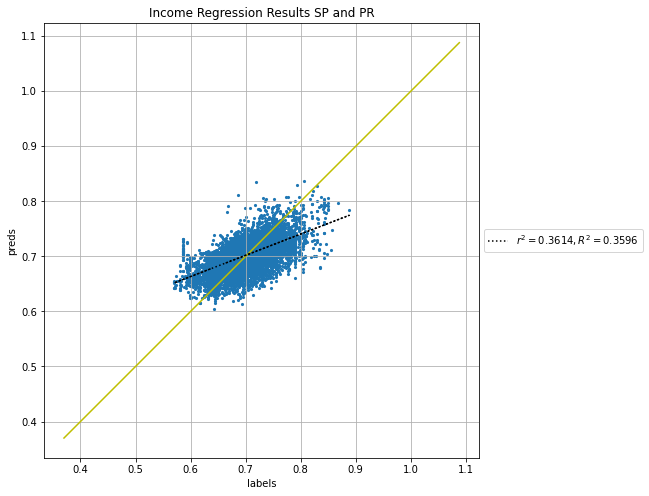

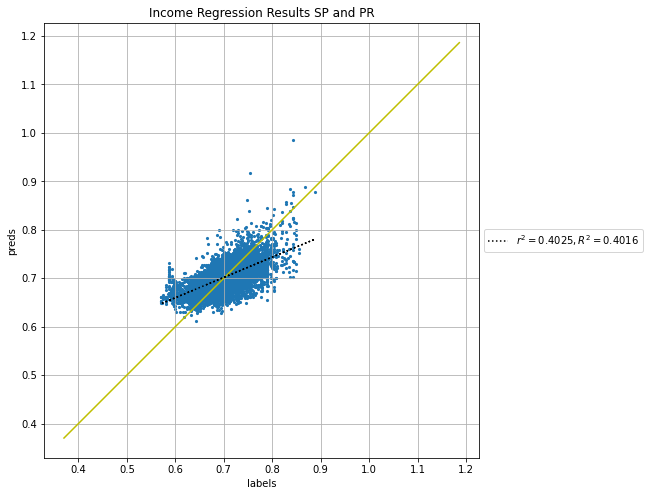

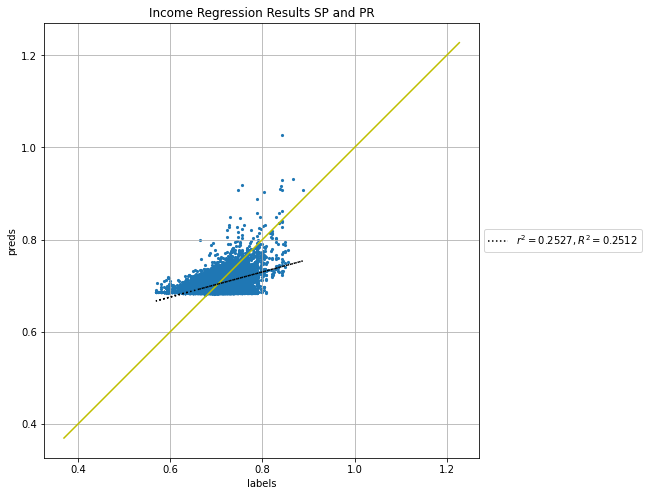

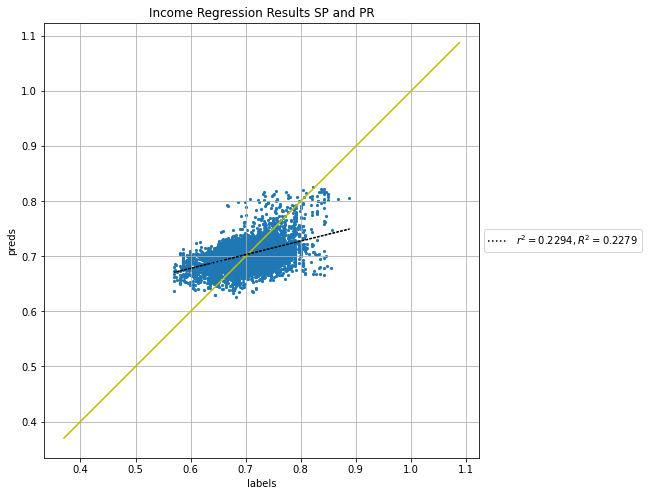

In [ ]:
for model_name in MODEL_NAMES:
    model_preds = preds[model_name]
    scatter_preds(
        labels=labels,
        preds=model_preds,
        title='Income Regression Results SP and PR',
        figsize=(8, 8))

In [ ]:
for model_name in MODEL_NAMES:
  print(model_name + ': HDI Income Regression Results Vale do Ribeira')

Resnet-18 MS: HDI Income Regression Results Vale do Ribeira
Resnet-18 MS+NL concat: HDI Income Regression Results Vale do Ribeira
Resnet-18 NL: HDI Income Regression Results Vale do Ribeira
Resnet-18 RGB: HDI Income Regression Results Vale do Ribeira


## Model Similarity Heatmaps

In [ ]:
model_names_by_mse = overall_df.sort_values(by='mse').index
num_models = len(preds)

r2_mat = np.eye(num_models, dtype=np.float64)
rank_mat = np.eye(num_models, dtype=np.float64)

for i, j in itertools.combinations(range(num_models), r=2):
    model_name1 = model_names_by_mse[i]
    model_name2 = model_names_by_mse[j]

    m1_preds = preds[model_name1]
    m2_preds = preds[model_name2]

    r2_mat[i, j] = calc_score(m1_preds, m2_preds, metric='r2')
    rank_mat[i, j] = calc_score(m1_preds, m2_preds, metric='rank')
    r2_mat[j, i] = r2_mat[i, j]
    rank_mat[j, i] = rank_mat[i, j]

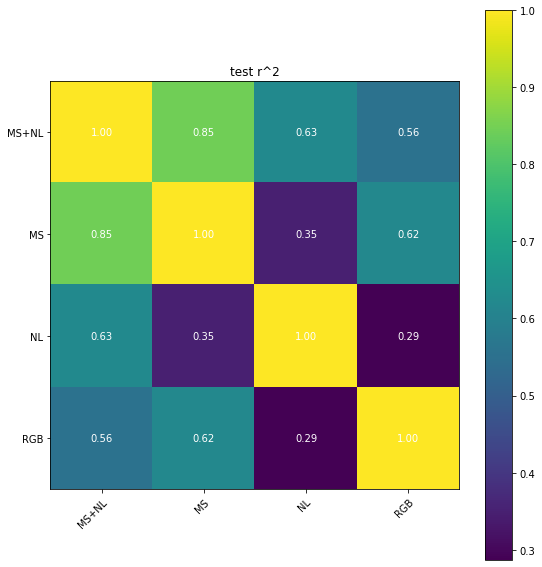

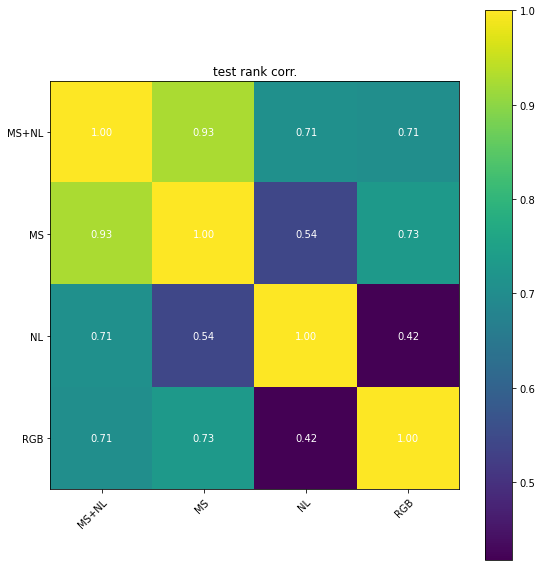

In [ ]:
symmetric_heatmap(r2_mat, labels=model_names_by_mse, format_spec='{:.2f}', title='test r^2', figsize=[8,8])
symmetric_heatmap(rank_mat, labels=model_names_by_mse, format_spec='{:.2f}', title='test rank corr.', figsize=[8,8])